In [1]:
import sys
sys.path.append('../')
sys.path.append('old/')

import matplotlib.pyplot as plt

import FiniteDifferences_ShortleyWeller_SquareGrid as PIC_FDSW
import FiniteDifferences_Staircase_SquareGrid as PIC_FD
import FFT_OpenBoundary_SquareGrid as PIC_FFT
import geom_impact_ellip as ell
from scipy import rand
import numpy as np

In [2]:
from pypic import PyPIC_Fortran_M2P_P2M, PyPIC
from meshing import RectMesh2D
from poisson_solver import FD_solver as FD
from poisson_solver.FD_solver import laplacian_2D_5stencil

pycuda not found. no gpu capabilities will be available
pycuda not found. no gpu capabilities will be available
GPU libraries (pycuda, cusolver_RF) not found. GPU functionality not available.


In [4]:
R_cham = 1e-1
R_charge = 4e-2
N_part_gen = 100000
Dh = 1e-3

from scipy.constants import e, epsilon_0

qe = e
eps0 = epsilon_0

chamber = ell.ellip_cham_geom_object(x_aper = R_cham, y_aper = R_cham)


poissonsolver = FD.FiniteDifferences_ShortleyWeller_SquareGrid(chamb=chamber, Dh=Dh)

mesh = RectMesh2D(poissonsolver.bias_x,
                  poissonsolver.bias_y,
                  Dh, Dh,
                  poissonsolver.Nxg,
                  poissonsolver.Nyg)

new_pp = PyPIC_Fortran_M2P_P2M(mesh, poissonsolver, gradient=poissonsolver.gradient)


picFD = PIC_FD.FiniteDifferences_Staircase_SquareGrid(chamb = chamber, Dh = Dh)
picFDSW = PIC_FDSW.FiniteDifferences_ShortleyWeller_SquareGrid(chamb = chamber, Dh = Dh)
picFFT = PIC_FFT.FFT_OpenBoundary_SquareGrid(x_aper = chamber.x_aper, y_aper = chamber.y_aper, Dh = Dh, fftlib='pyfftw')

Mat. assembly 0%
Using scipy superlu solver...
Done PIC init.
Start PIC init.:
Finite Differences, Square Grid
PyPIC Version 1.01
Mat. assembly 0%
Mat. assembly 5%
Mat. assembly 10%
Mat. assembly 15%
Mat. assembly 20%
Mat. assembly 25%
Mat. assembly 30%
Mat. assembly 35%
Mat. assembly 40%
Mat. assembly 45%
Mat. assembly 50%
Mat. assembly 55%
Mat. assembly 60%
Mat. assembly 65%
Mat. assembly 70%
Mat. assembly 75%
Mat. assembly 80%
Mat. assembly 85%
Mat. assembly 90%
Mat. assembly 95%
Mat. assembly 100%
Using scipy superlu solver...
Done PIC init.
Start PIC init.:
Finite Differences, Shortley-Weller, Square Grid
Using Shortley-Weller boundary approx.
PyPIC Version 1.01
Mat. assembly 0%
Mat. assembly 5%
Mat. assembly 10%
Mat. assembly 15%
Mat. assembly 20%
Mat. assembly 25%
Mat. assembly 30%
Mat. assembly 35%
Mat. assembly 40%
Mat. assembly 45%
Mat. assembly 50%
Mat. assembly 55%
Mat. assembly 60%
Mat. assembly 65%
Mat. assembly 70%
Mat. assembly 75%
Mat. assembly 80%
Mat. assembly 85%
Ma

In [5]:
# generate particles
x_part = R_charge*(2.*rand(N_part_gen)-1.)
y_part = R_charge*(2.*rand(N_part_gen)-1.)
mask_keep  = x_part**2+y_part**2<R_charge**2
x_part = x_part[mask_keep]
y_part = y_part[mask_keep]

nel_part = 0*x_part+1.

#pic scatter
picFD.scatter(x_part, y_part, nel_part, charge=e)
picFDSW.scatter(x_part, y_part, nel_part, charge=e)
picFFT.scatter(x_part, y_part, nel_part, charge=e)

mesh_charges = new_pp.particles_to_mesh(x_part, y_part, charge=e)
rho = mesh_charges/new_pp.mesh.volume_elem

#pic scatter
picFD.solve()
picFDSW.solve()
picFFT.solve()

phi = new_pp.poisson_solve(mesh_charges)
mesh_e_fields = new_pp.get_electric_fields(phi)
efx = mesh_e_fields[0]
efy = mesh_e_fields[1]
for i, field in enumerate(mesh_e_fields):
    mesh_e_fields[i] = field.flatten()




x_probes = np.linspace(0,R_cham,1000)
y_probes = 0.*x_probes

#pic gather
Ex_FD, Ey_FD = picFD.gather(x_probes, y_probes)
Ex_FDSW, Ey_FDSW = picFDSW.gather(x_probes, y_probes)
Ex_FFT, Ey_FFT = picFFT.gather(x_probes, y_probes)

mesh_fields_and_mp_coords = zip(list(mesh_e_fields), [x_probes, y_probes])
fields = new_pp.field_to_particles(*mesh_fields_and_mp_coords)

E_r_th = map(lambda x: np.sum(x_part**2+y_part**2<x**2)*qe/eps0/(2*np.pi*x), x_probes)

/home/stefan/miniconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:44: RuntimeWarning: invalid value encountered in double_scalars


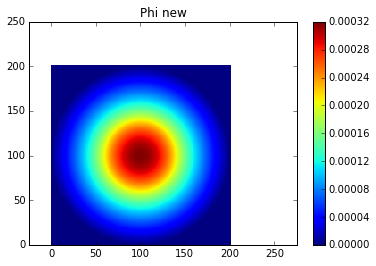

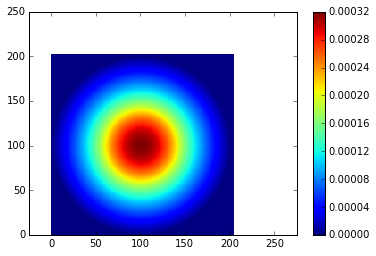

In [6]:
%matplotlib inline
plt.figure()
plt.pcolor(phi.reshape(mesh.ny, mesh.nx))
plt.colorbar()
plt.axis('equal')
plt.title('Phi new')
plt.show()

plt.figure()
plt.pcolor(picFDSW.phi.T[3:-2,4:-3])
plt.colorbar()
plt.axis('equal')
plt.show()

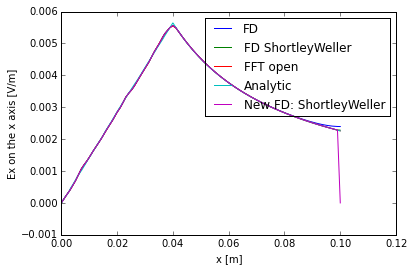

In [7]:
plt.close('all')
plt.plot(x_probes, Ex_FD, label = 'FD')
plt.plot(x_probes, Ex_FDSW, label = 'FD ShortleyWeller')
plt.plot(x_probes, Ex_FFT, label = 'FFT open')
plt.plot(x_probes, E_r_th, label = 'Analytic')
plt.plot(x_probes, fields[0], label = 'New FD: ShortleyWeller')
#pl.plot(picFFT.xg, picFFT.efx[picFFT.ny/2, :])
plt.legend()
plt.ylabel('Ex on the x axis [V/m]')
plt.xlabel('x [m]')

plt.show()